***FOREX FINACIAL BOT***

This project is for learning purpose only.
Alpha Vantage will be the main source of the real time data. By use of requests library I was able to import the API from Alpha.

In [28]:
import requests

api_key = 'CIVEY6DJ1KKAUPZK'
symbol = 'AAPL'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}'
response = requests.get(url)
data = response.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2024-04-24', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2024-04-24': {'1. open': '166.5400', '2. high': '169.3000', '3. low': '166.2100', '4. close': '169.0200', '5. volume': '48251835'}, '2024-04-23': {'1. open': '165.3500', '2. high': '167.0500', '3. low': '164.9200', '4. close': '166.9000', '5. volume': '49537761'}, '2024-04-22': {'1. open': '165.5150', '2. high': '167.2600', '3. low': '164.7700', '4. close': '165.8400', '5. volume': '48116443'}, '2024-04-19': {'1. open': '166.2100', '2. high': '166.4000', '3. low': '164.0750', '4. close': '165.0000', '5. volume': '68149377'}, '2024-04-18': {'1. open': '168.0300', '2. high': '168.6400', '3. low': '166.5500', '4. close': '167.0400', '5. volume': '43122903'}, '2024-04-17': {'1. open': '169.6100', '2. high': '170.6500', '3. low': '168.0000', '4. close': '168.0000', '5

**Data Preprocessing**

First, we shall start by converting the JSON data into a pandas dataframe.

In [29]:
import pandas as pd

df = pd.DataFrame(data['Time Series (Daily)']).T
df = df.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'})
df = df.astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)

print(df.head())
print(df.tail())

              Open    High       Low   Close      Volume
2023-11-30  189.84  190.32  188.1900  189.95  48794366.0
2023-12-01  190.33  191.56  189.2300  191.24  45704823.0
2023-12-04  189.98  190.05  187.4511  189.43  43389519.0
2023-12-05  190.21  194.40  190.1800  193.42  66628398.0
2023-12-06  194.45  194.76  192.1100  192.32  40895115.0
               Open    High      Low   Close      Volume
2024-04-18  168.030  168.64  166.550  167.04  43122903.0
2024-04-19  166.210  166.40  164.075  165.00  68149377.0
2024-04-22  165.515  167.26  164.770  165.84  48116443.0
2024-04-23  165.350  167.05  164.920  166.90  49537761.0
2024-04-24  166.540  169.30  166.210  169.02  48251835.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2023-11-30 to 2024-04-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    100 non-null    float64
 1   High    100 non-null    float64
 2   Low     100 non-null    float64
 3   Close   100 non-null    float64
 4   Volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB


In [31]:
df.describe()

,Open,High,Low,Close,Volume
count,100.000000,100.000000,100.00000,100.000000,1.000000e+02
mean,182.091300,183.481687,180.65341,182.160500,5.901654e+07
std,9.798328,9.630810,9.71668,9.801963,1.947680e+07
min,165.350000,166.400000,164.07500,165.000000,2.891931e+07
25%,171.757500,173.745000,170.45375,172.535000,4.628812e+07
50%,182.965000,184.902500,181.42500,183.745000,5.356441e+07
75%,190.407500,191.837500,188.92250,191.320000,6.716102e+07
max,198.020000,199.620000,197.00000,198.110000,1.366826e+08


**Visualizing the Data**

We shall use the matplotlib library to visualize the data. We shall plot the closing, opening, high and low price of the stock. All shall be plotted within a chart with multiple subplots.

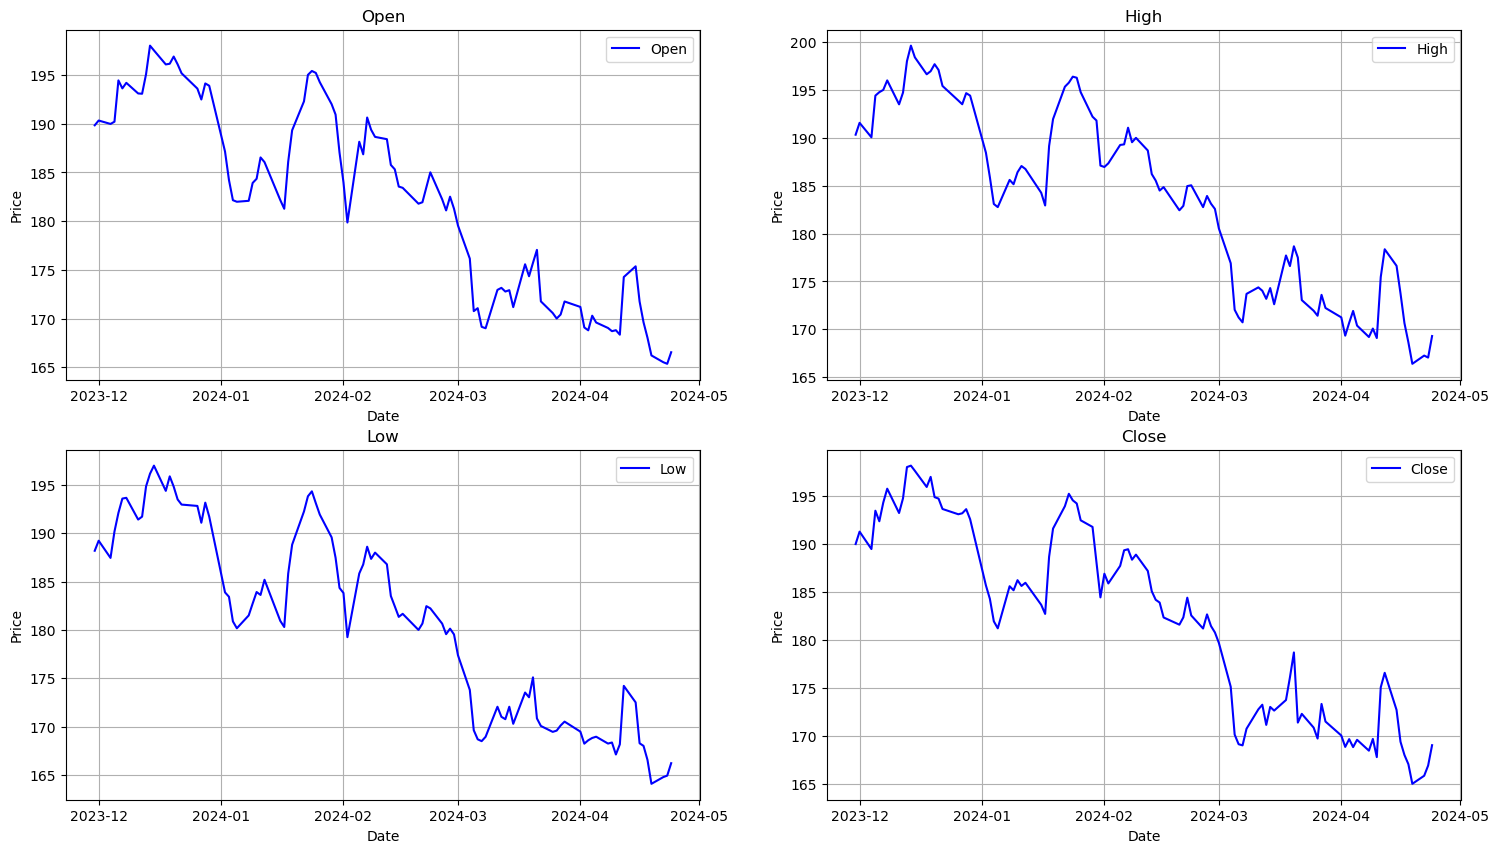

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
for c in df.columns:
    if c != 'Volume':
        plt.subplot(2, 2, list(df.columns).index(c) + 1)
        plt.plot(df.index, df[c], label=c, color = 'blue')
        plt.title(c)
        plt.legend()
        plt.grid()
        plt.xlabel('Date')
        plt.ylabel('Price')

plt.show()


**Feature Engineering**

We shall create a new column that will be the difference between the closing price and the opening price. This will be used to determine if the stock price increased or decreased.

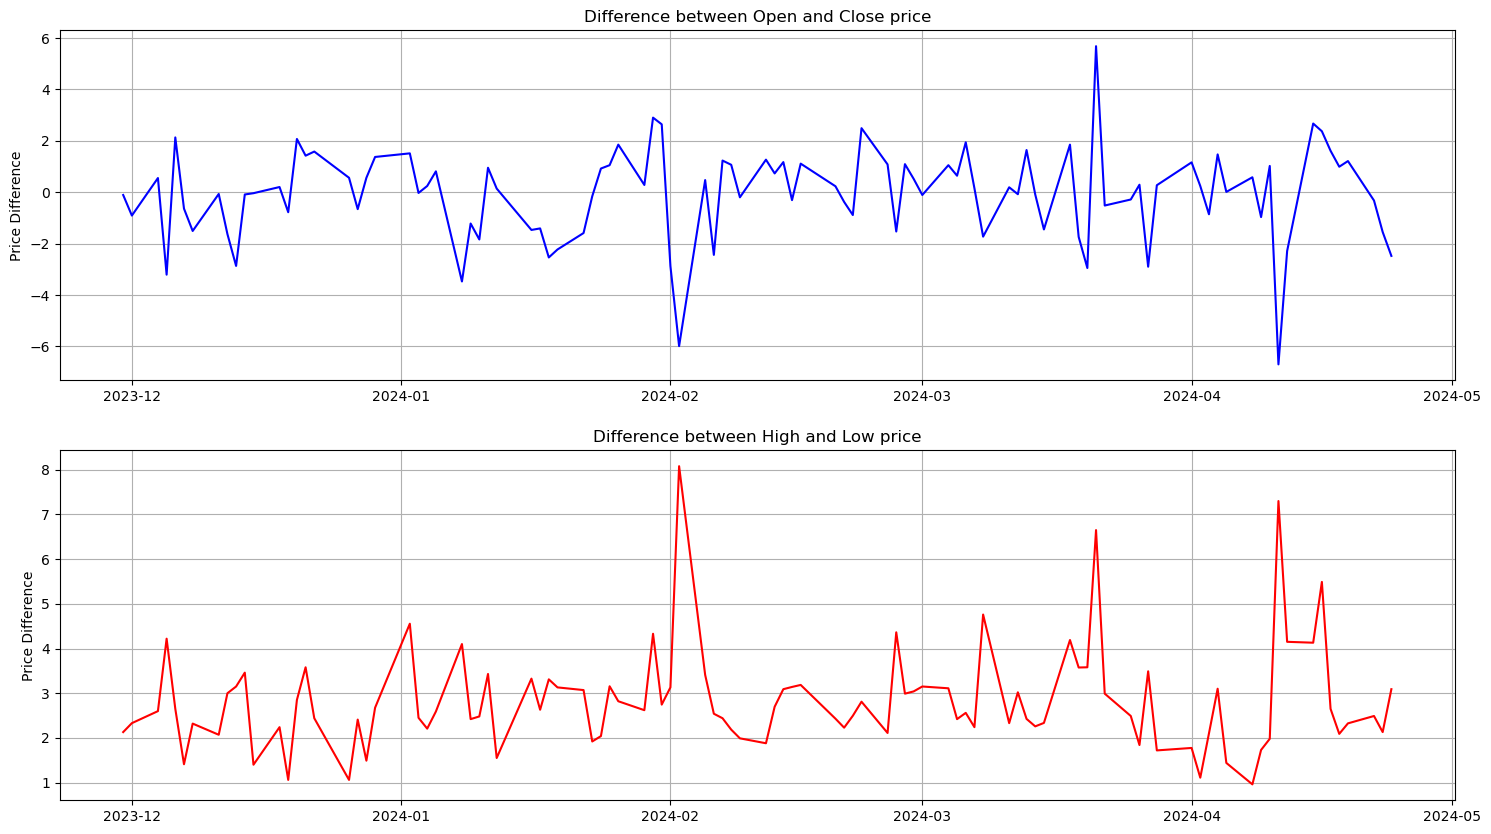

In [33]:
# finding difference between open and close price
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 1)    
plt.title('Difference between Open and Close price')
plt.plot(df.index, df['Open-Close'], color='blue')
plt.grid()
plt.ylabel('Price Difference')

plt.subplot(2, 1, 2)
plt.title('Difference between High and Low price')
plt.plot(df.index, df['High-Low'], color='red')
plt.grid()
plt.ylabel('Price Difference')

plt.show()

The difference above shows that the subtractions makes a stationary time series. This is important for the model to learn the patterns in the data.

**Moving Average Process**

We shall use Moving Average to smooth the data. This will help in removing the noise in the data. We shall use the 7 day moving average.

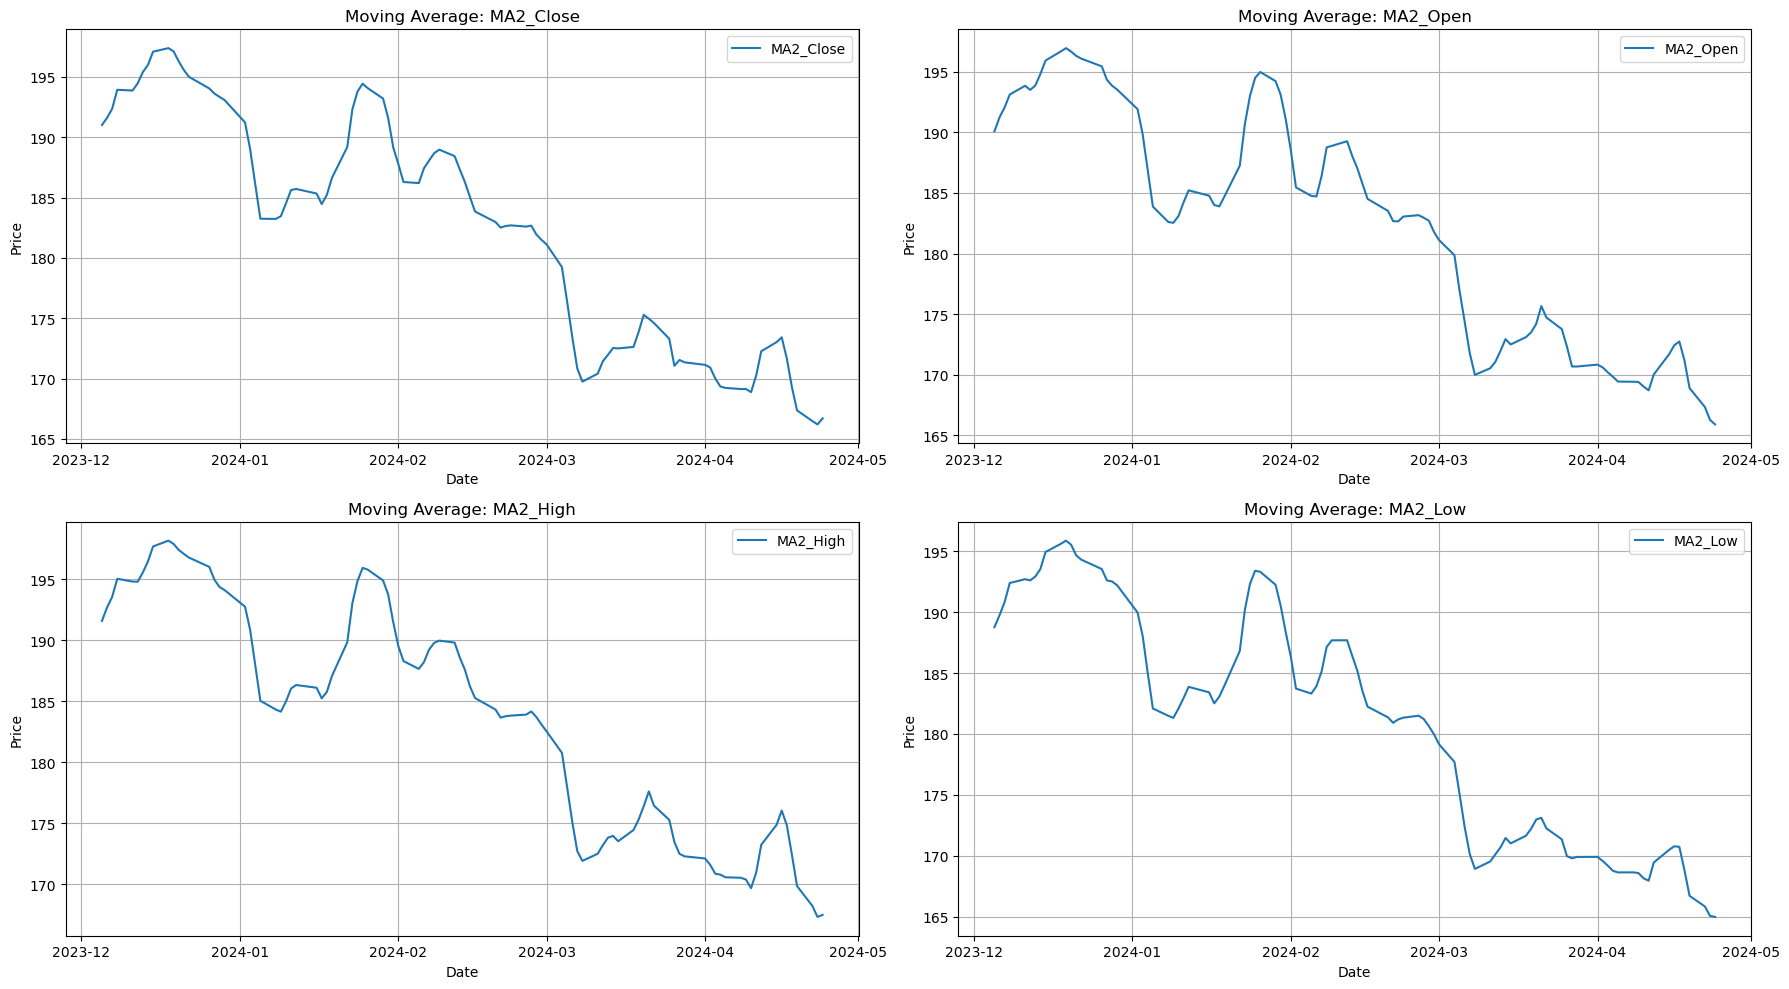

In [34]:
# Calculate moving averages
df['MA2_Close'] = df['Close'].rolling(window=4).mean()
df['MA2_Open'] = df['Open'].rolling(window=4).mean()
df['MA2_High'] = df['High'].rolling(window=4).mean()
df['MA2_Low'] = df['Low'].rolling(window=4).mean()

plt.figure(figsize=(18, 10))

# Loop through the moving averages and plot each one
for c in ['MA2_Close', 'MA2_Open', 'MA2_High', 'MA2_Low']:
    plt.subplot(2, 2, ['MA2_Close', 'MA2_Open', 'MA2_High', 'MA2_Low'].index(c) + 1)
    plt.plot(df.index, df[c], label=c)
    plt.title('Moving Average: ' + c)
    plt.legend()
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Price')

plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

Lets move to the next step of creating X and y then we train and test them.

In [48]:
X = df[['MA2_Close','MA2_Open', 'MA2_High', 'MA2_Low']]
y = df['Close']


print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")
print(X.tail())
print(y.tail())

Length of X: 100
Length of y: 100
            MA2_Close   MA2_Open  MA2_High    MA2_Low
2024-04-18   169.2775  171.18750  172.4200  168.83000
2024-04-19   167.3550  168.90000  169.8625  166.72375
2024-04-22   166.4700  167.34125  168.2375  165.84875
2024-04-23   166.1950  166.27625  167.3375  165.07875
2024-04-24   166.6900  165.90375  167.5025  164.99375
2024-04-18    167.04
2024-04-19    165.00
2024-04-22    165.84
2024-04-23    166.90
2024-04-24    169.02
Name: Close, dtype: float64


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80, 4)
(20, 4)
(80,)
(20,)


Now we can do the linear regression on the model. Also, we can do Mean Squared Error to check the accuracy of the model. 